In [50]:
import os
import operator
import random
import numpy as np
import pandas as pd
import csv
import re

from itertools import chain, islice
from functools import partial

import nltk
from nltk.tokenize import word_tokenize

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import InputLayer, Embedding, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
from pprint import pprint

import gc

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)
    
set_seed(1992)

<h2>Preprocessing</h2>

We operate on a subset of two datasets:
<ol>
    <li>
        <h4>LingSpam Dataset (Bare)</h4>
        <p>
            This is the dataset that we used in the 2nd assignment.
            It consists of a few large emails, appriximately 1000 messages with an average of 3500 words.
    </li>
    <li>
        <h4>Kaggles Spam/Ham Dataset</h4>
        <p>
            This dataset is bigger, consisting of approximately 5500 messages.
            Each messagehowever is quiet short and a lot of jargon is used in them.
        </p>
    </li>
</ol>

In [3]:
lingspam_data_path = "lingspam_public/bare"
kaggle_data_path   = "Kaggle/kaggle_spam_data.csv"

In [4]:
def load_lingspam_data(path):

    ham, spam = [], []

    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            with open(os.path.join(dirpath, filename), encoding="utf8") as file:
                message = file.read()
            if filename.startswith("spm"):
                spam.append(message)
            else:
                ham.append(message)

    return ham, spam

In [5]:
def load_kaggle_data(path):
    
    ham, spam = [], []
    
    pattern = re.compile("\"?(?P<Category>spam|ham),(?:\"\")?(?P<Text>.*?)(?:\"\"\")?;+")
    
    with open(path, 'r', encoding="utf8") as file:
        for line in file.readlines():
            match = pattern.match(line)
            if match:
                text = " ".join(word_tokenize(match["Text"]))
                if match["Category"].startswith("s"):
                    spam.append(text)
                else:
                    ham.append(text)
            
    return ham, spam

In [81]:
dataset = "*" # Specify the dataset to be loaded: kaggle, lingspam, or both

ham, spam = \
    load_kaggle_data(kaggle_data_path) if dataset.startswith("k") else (
        load_lingspam_data(lingspam_data_path) if dataset.startswith("l") else
        tuple(map(operator.concat, load_kaggle_data(kaggle_data_path), load_lingspam_data(lingspam_data_path)))
    )
 
print("Ham: {}, Spam: {}".format(len(ham), len(spam)))

Ham: 7226, Spam: 1227


In [82]:
def data_split(x, y, sizes=(0.1, 0.1)):
    
    data_size = len(x)
    splits = []
    
    for size in sizes:
        x, test_x, y, test_y = train_test_split(x, y, test_size=int(data_size*size), shuffle=True)
        splits.append((test_x, test_y))
    splits.append((x, y))
    
    return splits

In [83]:
x = ham + spam
y = [0] * len(ham) + [1] * len(spam)

(test_x, test_y), (valid_x, valid_y), (train_x, train_y) = data_split(x, y, sizes=(0.2, 0.08))

print("Split Sizes: {}".format(list(map(len, (train_x, valid_x, test_x)))))

Split Sizes: [6087, 676, 1690]


<h3>Tokenizer Initialization</h3>
<p>We consider two tokenizers. <i>Tokenizer_TRAIN_GLB</i> is fitted in all tokens onservable in the training set. <i>Tokenizer_UNK</i> is fitted in a subset of the training sequences in order to simulate the unobservability of a number of tokens in the validation data.</p>

In [11]:
tokenizer_GLB = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_GLB.fit_on_texts(train_x)

print("Tokens discovered by Tokenizer_GLB: {}".format(len(tokenizer_GLB.word_index)))

Tokens discovered by Tokenizer_GLB: 50155


In [12]:
tokenizer_UNK = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_UNK.fit_on_texts(random.sample(train_x, len(train_x) - len(valid_x))) # We want the number of unknown words in the train set to be approximately the same as in the validation set.

print("Tokens discovered by Tokenizer_UNK: {}".format(len(tokenizer_UNK.word_index)))

Tokens discovered by Tokenizer_UNK: 47449


<h3>Tokenization</h3>
<p>We transform each set in sequences of tokens according the chosen tokenizer.</p>

In [13]:
tokenizer = tokenizer_UNK

In [14]:
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=150, padding="post", truncating="post") # We are contrained by the hardware limitations.
input_length = len(train_sequences[0])

In [15]:
valid_sequences = pad_sequences(tokenizer.texts_to_sequences(valid_x), maxlen=input_length, padding="post", truncating="post")
test_sequences  = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=input_length, padding="post", truncating="post")

<h3>TF-IDF Vectorizaton</h3>

In [105]:
tdidf_cevtorizer = TfidfVectorizer(
    input="content",
    analyzer="word",
    stop_words="english",
    #token_pattern="[^ ]+",
    ngram_range=(1, 3),
    min_df=10,
    max_df=0.8,
    max_features=150
)

In [106]:
train_tfidf = tdidf_cevtorizer.fit_transform(train_x)

In [107]:
valid_tfidf = tdidf_cevtorizer.transform(valid_x)
test_tfidf = tdidf_cevtorizer.transform(test_x)

<h2>Utilities</h2>

In [17]:
def clean_model(model):
    
    K.clear_session()
    del model
    gc.collect() 

In [18]:
def plot_history(history):
    
    plt.plot(
        history.history["acc"],
        label="Train"
    )
    plt.plot(
        history.history["val_acc"],
        label="Validation"
    )
    
    plt.title("Model Accuracy")
    plt.ylabel("Accuray")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="best")
    
    plt.show() 

In [19]:
def evaluate_model(model, sequences, y):
    
    print(classification_report(y, (model.predict(sequences).flatten() >= 0.5).astype(float)))

<h2>MLP on Pretrained (Glove) Embeddings</h2>

In [41]:
glove_embeddings_path = "glove.6B/glove.6B.100d.txt"
embeddings_df = pd.read_csv(glove_embeddings_path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE, na_values=None, keep_default_na=False)

In [42]:
token_iter = map(
    operator.itemgetter(0),
    sorted(
        filter(lambda item: item[1] <= tokenizer.num_words, tokenizer.word_index.items()) if tokenizer.num_words
            else tokenizer.word_index.items(),
        key=operator.itemgetter(1)
    )
)

embedding_weights = embeddings_df.reindex(chain((None,), token_iter), fill_value=0.0).values # The zero-indexed vector is used only for masking by the layer.

print("Non-Zero Embeddings: {}".format(np.count_nonzero(embedding_weights, axis=0)[0]))

Non-Zero Embeddings: 34061


In [53]:
model = Sequential(name="MLP")

model.add(Embedding(
    input_dim=embedding_weights.shape[0],
    output_dim=embedding_weights.shape[1],
    input_length=input_length,
    embeddings_initializer="zeros",
    weights=[embedding_weights],
    trainable=False
))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          5146900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1500100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total para

In [54]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [55]:
history = model.fit(
    train_sequences, train_y,
    validation_data=(valid_sequences, valid_y),
    batch_size=16,
    epochs=100,
    callbacks=[EarlyStopping(patience=6, restore_best_weights=True, verbose=1)],
    verbose=1
)

Train on 6087 samples, validate on 676 samples
Epoch 1/100
6087/6087 [==============================] - 4s 604us/step - loss: 0.3566 - acc: 0.8679 - val_loss: 0.1517 - val_acc: 0.9408
Epoch 2/100
6087/6087 [==============================] - 3s 454us/step - loss: 0.1678 - acc: 0.9290 - val_loss: 0.0663 - val_acc: 0.9749
Epoch 3/100
6087/6087 [==============================] - 3s 458us/step - loss: 0.1216 - acc: 0.9532 - val_loss: 0.0760 - val_acc: 0.9749
Epoch 4/100
6087/6087 [==============================] - 3s 466us/step - loss: 0.0996 - acc: 0.9586 - val_loss: 0.0866 - val_acc: 0.9734
Epoch 5/100
6087/6087 [==============================] - 3s 461us/step - loss: 0.0900 - acc: 0.9617 - val_loss: 0.0597 - val_acc: 0.9837
Epoch 6/100
6087/6087 [==============================] - 3s 453us/step - loss: 0.0610 - acc: 0.9727 - val_loss: 0.0653 - val_acc: 0.9808
Epoch 7/100
6087/6087 [==============================] - 3s 453us/step - loss: 0.0844 - acc: 0.9731 - val_loss: 0.0621 - val_acc: 0

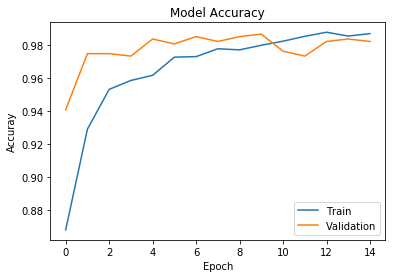

In [56]:
plot_history(history)

In [57]:
evaluate_model(model, train_sequences, train_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5182
           1       1.00      0.99      0.99       905

   micro avg       1.00      1.00      1.00      6087
   macro avg       1.00      0.99      1.00      6087
weighted avg       1.00      1.00      1.00      6087



In [58]:
evaluate_model(model, valid_sequences, valid_y)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       585
           1       0.99      0.90      0.94        91

   micro avg       0.99      0.99      0.99       676
   macro avg       0.99      0.95      0.97       676
weighted avg       0.99      0.99      0.98       676



In [59]:
evaluate_model(model, test_sequences, test_y)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1459
           1       0.93      0.87      0.90       231

   micro avg       0.97      0.97      0.97      1690
   macro avg       0.95      0.93      0.94      1690
weighted avg       0.97      0.97      0.97      1690



In [52]:
clean_model(model)

<h2>MLP on TF-IDF Vectors</h2>

In [109]:
model = Sequential(name="MLP")

model.add(InputLayer((train_tfidf.shape[1],), sparse=True))
model.add(Dense(2000, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(500, kernel_initializer="glorot_normal"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_normal"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              302000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               200100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               50500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
__________

In [110]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [111]:
history = model.fit(
    train_tfidf, train_y,
    validation_data=(valid_tfidf, valid_y),
    batch_size=16,
    epochs=100,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True, verbose=1)],
    verbose=1
)

Train on 6087 samples, validate on 676 samples
Epoch 1/100
6087/6087 [==============================] - 5s 795us/step - loss: 0.3080 - acc: 0.8802 - val_loss: 0.1791 - val_acc: 0.9349
Epoch 2/100
6087/6087 [==============================] - 3s 544us/step - loss: 0.2055 - acc: 0.9384 - val_loss: 0.1689 - val_acc: 0.9423
Epoch 3/100
6087/6087 [==============================] - 3s 541us/step - loss: 0.1827 - acc: 0.9441 - val_loss: 0.1558 - val_acc: 0.9482
Epoch 4/100
6087/6087 [==============================] - 3s 527us/step - loss: 0.1745 - acc: 0.9468 - val_loss: 0.1589 - val_acc: 0.9527
Epoch 5/100
6087/6087 [==============================] - 3s 533us/step - loss: 0.1610 - acc: 0.9525 - val_loss: 0.1568 - val_acc: 0.9438
Epoch 6/100
6087/6087 [==============================] - 3s 531us/step - loss: 0.1593 - acc: 0.9535 - val_loss: 0.1521 - val_acc: 0.9467
Epoch 7/100
6087/6087 [==============================] - 3s 518us/step - loss: 0.1605 - acc: 0.9547 - val_loss: 0.1603 - val_acc: 0

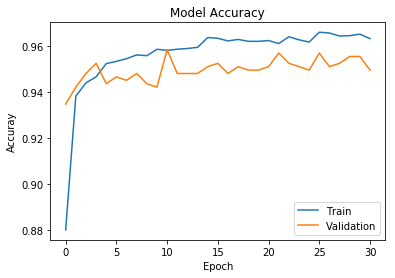

In [112]:
plot_history(history)

In [113]:
evaluate_model(model, train_tfidf, train_y)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5208
           1       0.93      0.82      0.87       879

   micro avg       0.97      0.97      0.97      6087
   macro avg       0.95      0.91      0.93      6087
weighted avg       0.96      0.97      0.96      6087



In [114]:
evaluate_model(model, valid_tfidf, valid_y)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       576
           1       0.89      0.82      0.85       100

   micro avg       0.96      0.96      0.96       676
   macro avg       0.93      0.90      0.92       676
weighted avg       0.96      0.96      0.96       676



In [115]:
evaluate_model(model, test_tfidf, test_y)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1442
           1       0.85      0.78      0.81       248

   micro avg       0.95      0.95      0.95      1690
   macro avg       0.91      0.88      0.89      1690
weighted avg       0.95      0.95      0.95      1690



In [108]:
clean_model(model)